In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import StratifiedShuffleSplit


Let's import the training data first

In [2]:
# importing the data set as a dataframe
df_org = pd.read_csv("MATG557_S22MidtermTrainingSet.csv", index_col=[0])
df2 = df_org.copy()
# replacing "?" with NaN
df2 = df2.replace('?', np.NaN)
df2.head()


,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Blind_Make,Blind_Model,Blind_Submodel,Cat1,Cat2,...,Var5,Var6,Var7,Var8,NVCat,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
1,10454936,6465585,1,2005,2000,AL,AL.46,AL.46.0,A,C,...,-0.186464,-0.107419,-0.763322,1.951802,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
2,4155346,2606426,2,2007,1997,AJ,AJ.122,AJ.122.3,D,NaN,...,0.610453,-0.405695,0.170537,-0.939473,J,-0.23153,4.308482,-0.272337,-0.251419,0.0
3,2738464,1939998,2,2006,1989,K,K.8,K.8.1,B,NaN,...,-0.537345,-0.569455,-1.058225,-0.524981,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0
4,5275517,3663973,2,2007,2005,AU,AU.16,AU.16.0,I,C,...,0.937546,1.849506,1.546749,1.265357,O,-0.23153,-0.266117,-0.272337,-0.251419,0.0
5,3493952,2267972,2,2005,2003,AJ,AJ.58,AJ.58.2,D,C,...,2.043715,0.745300,1.239559,0.032490,M,-0.23153,-0.266117,-0.272337,-0.251419,0.0


Let's take a look at correlation coefficients

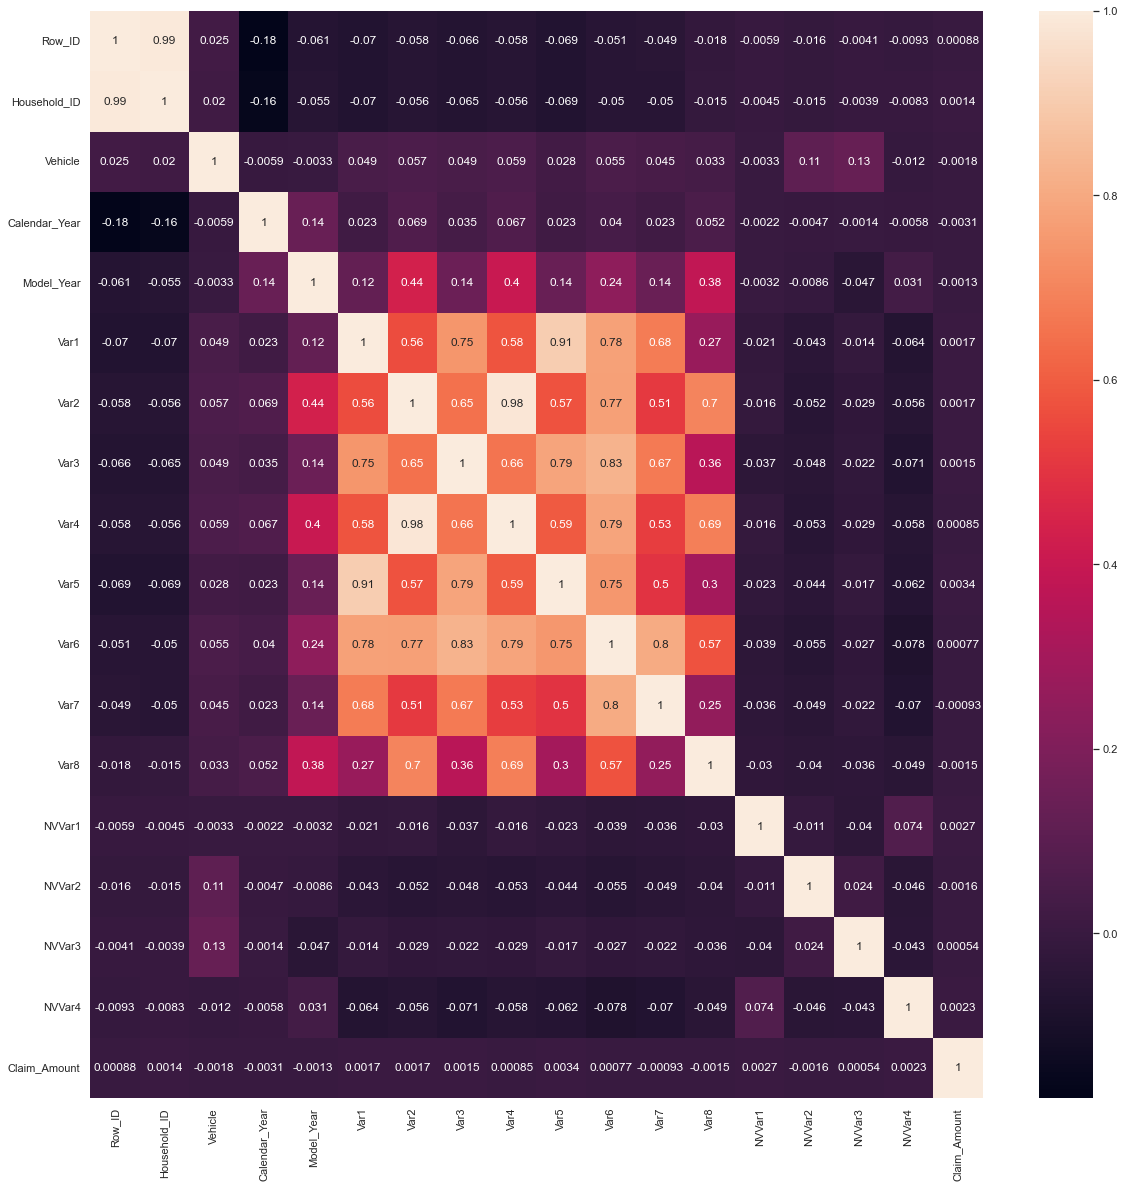

In [3]:
sns.set(rc={'figure.figsize':(20,20)})
dataplot = sns.heatmap(df2.corr(), annot=True)

Since there seems be a strong correlation between `Var1` and `Var5` as well as `Var2` and `Var4`, I will only use one of each pair for developing my regression model. In other words, I will drop `Var1` and `Var2` for regression model development and keep `Var4` and `Var5`. For the target variable (`Claim_Amount`), the highest correlations are with `Var5` and `Calendar_Year`, followed by `NVVar1` and `NVVar4`.

In [4]:
np.abs(df2.corr().iloc[:,17]).sort_values(ascending=False)[:5]

Claim_Amount     1.000000
Var5             0.003405
Calendar_Year    0.003135
NVVar1           0.002682
NVVar4           0.002297
Name: Claim_Amount, dtype: float64

We can also look at the pairwise plots for some of the variables

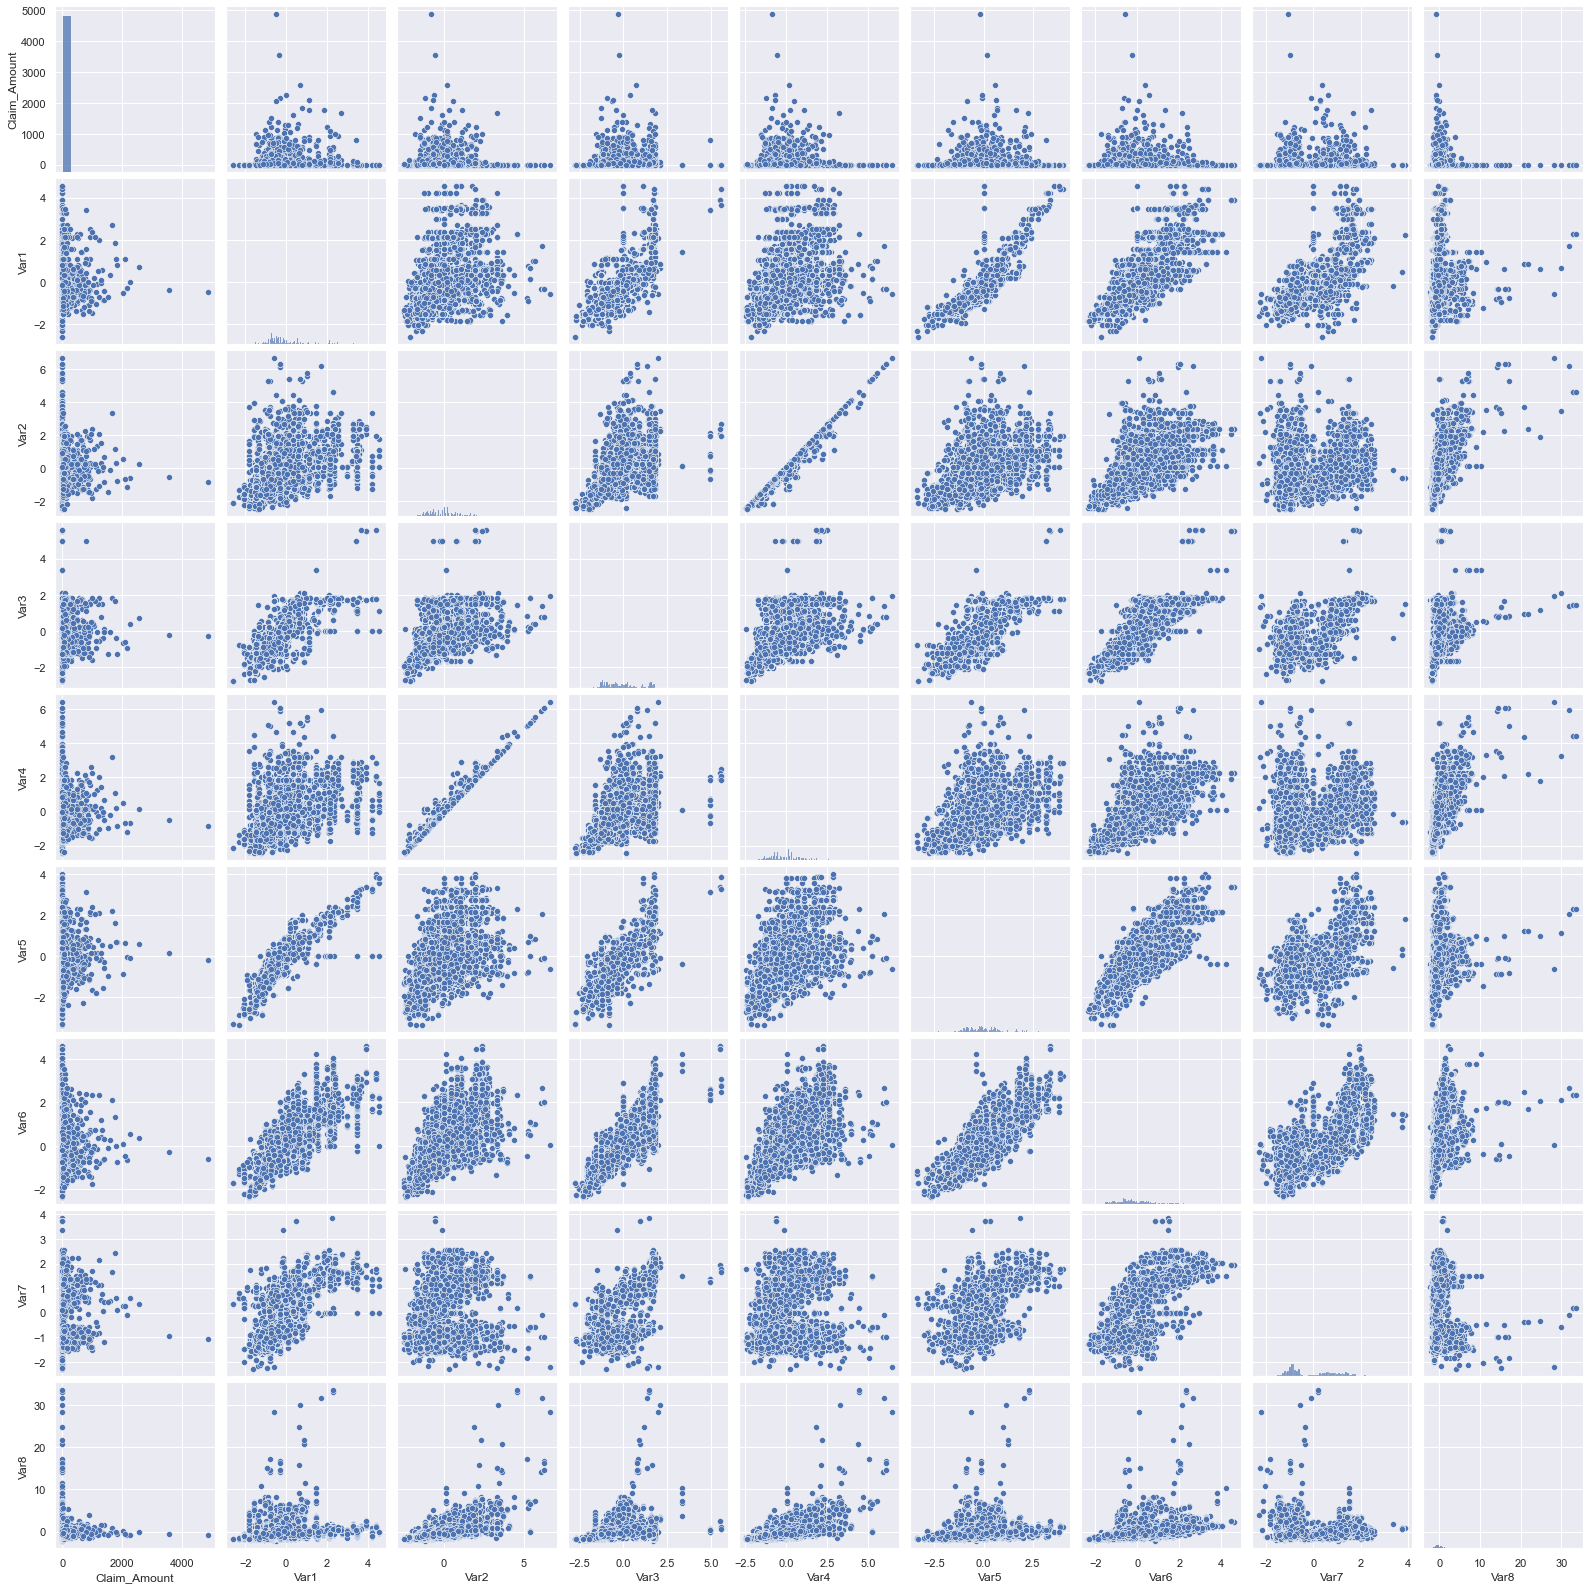

In [5]:
attributes = ['Claim_Amount', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8']
df_pair_plt = df2[attributes]
sns.set(rc={'figure.figsize':(20,20)})
sns.pairplot(df_pair_plt)

Let's take a quick look at the five-number summary statistics for non-categorical variables along with mean and standard deviation values.

In [6]:
df2.describe()

,Row_ID,Household_ID,Vehicle,Calendar_Year,Model_Year,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,NVVar3,NVVar4,Claim_Amount
count,1.010000e+05,1.010000e+05,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000,101000.000000
mean,6.609325e+06,4.138274e+06,1.892238,2006.055485,1999.334594,-0.008217,-0.063985,-0.022461,-0.053780,0.006222,-0.037948,-0.021555,-0.055834,0.017585,0.014596,0.013705,0.013328,1.804594
std,3.807270e+06,2.248616e+06,1.181669,0.812097,5.217685,0.982394,0.966146,1.019024,0.965738,0.991784,0.979590,1.007220,1.010723,1.038779,1.027766,1.024550,1.023024,39.917091
min,4.410000e+02,2.330000e+02,1.000000,2005.000000,1981.000000,-2.578222,-2.458811,-2.744055,-2.423648,-3.350344,-2.334547,-2.286986,-2.163042,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
25%,3.311167e+06,2.203242e+06,1.000000,2005.000000,1996.000000,-0.665897,-0.816152,-0.869687,-0.783019,-0.686024,-0.687595,-0.898486,-0.650127,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
50%,6.627712e+06,4.268464e+06,2.000000,2006.000000,2000.000000,-0.296288,-0.124506,-0.198618,-0.106471,-0.115098,-0.231408,-0.468419,-0.254669,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
75%,9.906754e+06,6.286856e+06,2.000000,2007.000000,2003.000000,0.442930,0.480684,0.726996,0.485509,0.550982,0.497321,0.821780,0.341855,-0.231530,-0.266117,-0.272337,-0.251419,0.000000
max,1.318414e+07,7.541990e+06,20.000000,2007.000000,2008.000000,4.540768,6.636331,5.563325,6.422217,4.006272,4.584289,3.844533,33.457740,6.627110,8.883081,8.691144,6.388802,4877.531000


Based on the results, it seems like that the `Claim_Amount` distribution has a lot of variance around the mean. The range for that variable is also large, from minimum of 0 to maximum of 4877.531. We can see that in the distribution plot for `Claim_Amount` as well.  

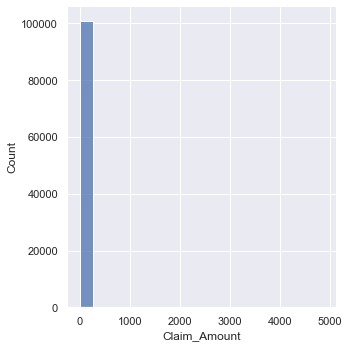

In [7]:
sns.displot(data=df2, x="Claim_Amount")

let's look into the missing values

In [8]:
rows_with_NAs = df2[df2.isnull().any(axis=1)]
print(f"There are {len(rows_with_NAs)} number of rows with at least one missing value.")

There are 72399 number of rows with at least one missing value.


Let's look into the datatype for each column.

In [9]:
df2.dtypes

Row_ID              int64
Household_ID        int64
Vehicle             int64
Calendar_Year       int64
Model_Year          int64
Blind_Make         object
Blind_Model        object
Blind_Submodel     object
Cat1               object
Cat2               object
Cat3               object
Cat4               object
Cat5               object
Cat6               object
Cat7               object
Cat8               object
Cat9               object
Cat10              object
Cat11              object
Cat12              object
OrdCat             object
Var1              float64
Var2              float64
Var3              float64
Var4              float64
Var5              float64
Var6              float64
Var7              float64
Var8              float64
NVCat              object
NVVar1            float64
NVVar2            float64
NVVar3            float64
NVVar4            float64
Claim_Amount      float64
dtype: object

Let's make the categorical variables as `Category` type.

In [10]:
# nominal variables
cat_var = ['Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'NVCat']
df2[cat_var] = df2[cat_var].astype("category")
# Ordinal variable
df2['OrdCat'] = pd.Categorical(df2['OrdCat'], categories=pd.factorize(df2['OrdCat'], sort=True)[1], ordered=True)
print(df2.dtypes)

Row_ID               int64
Household_ID         int64
Vehicle              int64
Calendar_Year        int64
Model_Year           int64
Blind_Make          object
Blind_Model         object
Blind_Submodel      object
Cat1              category
Cat2              category
Cat3              category
Cat4              category
Cat5              category
Cat6              category
Cat7              category
Cat8              category
Cat9              category
Cat10             category
Cat11             category
Cat12             category
OrdCat            category
Var1               float64
Var2               float64
Var3               float64
Var4               float64
Var5               float64
Var6               float64
Var7               float64
Var8               float64
NVCat             category
NVVar1             float64
NVVar2             float64
NVVar3             float64
NVVar4             float64
Claim_Amount       float64
dtype: object


Let's look at the number of missing values in each column.

For column Row_ID, there are 0 number of missing values, 0.0000% of total rows
For column Household_ID, there are 0 number of missing values, 0.0000% of total rows
For column Vehicle, there are 0 number of missing values, 0.0000% of total rows
For column Calendar_Year, there are 0 number of missing values, 0.0000% of total rows
For column Model_Year, there are 0 number of missing values, 0.0000% of total rows
For column Blind_Make, there are 55 number of missing values, 0.0005% of total rows
For column Blind_Model, there are 55 number of missing values, 0.0005% of total rows
For column Blind_Submodel, there are 55 number of missing values, 0.0005% of total rows
For column Cat1, there are 231 number of missing values, 0.0023% of total rows
For column Cat2, there are 37228 number of missing values, 0.3686% of total rows
For column Cat3, there are 25 number of missing values, 0.0002% of total rows
For column Cat4, there are 43208 number of missing values, 0.4278% of total rows
For column 

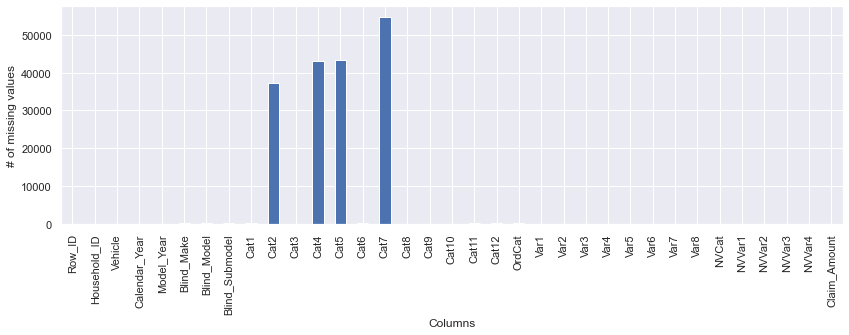

In [11]:
plt.figure(figsize=(14,4))
df2.isnull().sum().plot.bar()
plt.xlabel("Columns")
plt.ylabel("# of missing values");

for col in df2.columns:
    tmp_NAs = df2[col].isnull().sum()
    print(f"For column {col}, there are {tmp_NAs} number of missing values, {tmp_NAs/len(df2):.4f}% of total rows")

So the main columns with missing values `Cat2`, `Cat4`, `Cat5`, and `Cat7` with 37,228, 43,208, 43,249, and 54,851 missing values respectively. Further, it seems like the columns with numerical datatype do not have missing values. For the columns with categorical values, I replace the missing values with the most common category in those columns.

In [12]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy="most_frequent")
df = pd.DataFrame(imp.fit_transform(df2), columns=df2.columns).astype(df2.dtypes.to_dict())

We have a target variable with so many 0's, i.e. very unbalanced data. Let's see how bad the situation is...

In [13]:
portion_non_0=len(df[df["Claim_Amount"]>0]['Claim_Amount'])
portion_0=len(df[df["Claim_Amount"]==0]['Claim_Amount'])
print(f"Only {portion_non_0/portion_0*100}% of claims are non-zero")

Only 1.0% of claims are non-zero


So I am going to split the data into training and testing using the Stratified approach.

1    100024
6       510
5       179
3       100
4        98
2        89
Name: Claim_Cat, dtype: int64


<AxesSubplot:>

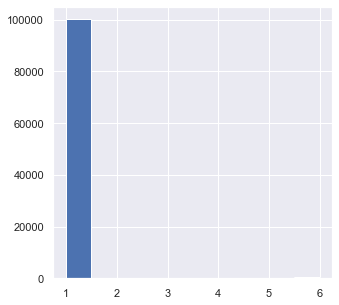

In [14]:
# Here we consider stratified sampling by claim category
df["Claim_Cat"] = pd.cut(df["Claim_Amount"],
                               bins=[0, 1, 4, 10, 20, 50, np.inf],
                               labels=[1, 2, 3, 4, 5, 6],
                               include_lowest=True,
                               ordered=True)
print( df['Claim_Cat'].value_counts() )

plt.figure(figsize=(5,5))
df['Claim_Cat'].hist()

In [15]:
dfc = df.copy()

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
index_list = list(split.split(dfc, dfc["Claim_Cat"]))
dfc_train = dfc.iloc[index_list[0][0]]
dfc_test = dfc.iloc[index_list[0][1]]

In [17]:
def claim_cat_proportions(data):
    return data["Claim_Cat"].value_counts() / len(data)

train_set, test_set = train_test_split(dfc, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": claim_cat_proportions(dfc),
    "Stratified": claim_cat_proportions(dfc_train),
    "Random": claim_cat_proportions(dfc_test),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.990337,0.990334,0.990347,0.001000,-0.000250
2,0.000881,0.000879,0.000891,1.123596,-0.280899
3,0.000990,0.000990,0.000990,0.000000,0.000000
4,0.000970,0.000978,0.000941,-3.061224,0.765306
5,0.001772,0.001770,0.001782,0.558659,-0.139665
6,0.005050,0.005050,0.005050,0.000000,0.000000


In [18]:
def  MultiLinear(df_inp, predictors, algorithm='OLS'):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'


    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    index_list = list(split.split(df_inp, df_inp["Claim_Cat"]))
    dfc_train_inp = df_inp.iloc[index_list[0][0]]
    dfc_test_inp = df_inp.iloc[index_list[0][1]]

    # training data
    y_train = np.array( dfc_train_inp['Claim_Amount'])
    x_train = np.array( dfc_train_inp[predictors] )
    # test data
    y_test = np.array(dfc_test_inp['Claim_Amount'])
    x_test = np.array( dfc_test_inp[predictors] )

    # ordinary least squares
    if algorithm == 'OLS':
        # define model and fit
        model = LinearRegression().fit(x_train, y_train)
    
    # Ridge or LASSO regression
    elif algorithm == 'RG' or 'LSO':
        if algorithm == 'RG':
            # define model and fit
            model = Ridge().fit(x_train, y_train)
            
        elif algorithm == 'LSO':
            # define model and fit
            model = Lasso().fit(x_train, y_train)
            
        # Define Cross Validation
        cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=23)
        # random state intialization makes the result reproducible
        # define grid
        grid = dict()
        grid['alpha'] = 10**np.arange(-3, 3, 0.005)
        # define search
        search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        # n_jobs=-1 allows parallel implementation in multiple processors

        # perform the search
        results = search.fit(x_train, y_train)
        # The CV picks the best alpha
        if algorithm == 'RG':
            model = Ridge(alpha = results.best_params_['alpha']).fit(x_train, y_train)
        elif algorithm == 'LSO':
            model = Lasso(alpha = results.best_params_['alpha']).fit(x_train, y_train)
        # We fit the model to the data
        model.fit(x_train, y_train)


    # make predictions
    yhat_tr = model.predict(x_train)
    yhat_ts = model.predict(x_test)
    # calculate errors/scores
    # RMSEs
    RMSE_tr=mean_squared_error(y_train ,yhat_tr, squared=False)
    RMSE_ts=mean_squared_error(y_test, yhat_ts, squared=False)
    RMSEs = [RMSE_tr,RMSE_ts]
    # MAEs
    MAE_tr=mean_absolute_error(y_train, yhat_tr)
    MAE_ts=mean_absolute_error(y_test, yhat_ts)
    MAEs = [MAE_tr,MAE_ts]
    # R2s
    r2score_tr = r2_score(y_train, yhat_tr)
    r2score_ts = r2_score(y_test, yhat_ts)
    R2s = [r2score_tr, r2score_ts]

    return RMSEs, R2s, MAEs, model

In [19]:
predict = ['Calendar_Year', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
#predict = ['Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8']#, 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
RMSEs, R2s, MAEs, lrm = MultiLinear(dfc, predictors=predict)

In [20]:
print(f'The value of root mean squared error is: {RMSEs[0]:.4f} (training)')
print(f'The value of root mean squared error is: {RMSEs[1]:.4f} (testing)')

print(f'The value of R2 is: {R2s[0]:.4f} (training)')
print(f'The value of R2 is: {R2s[1]:.4f} (testing)')

print(f'The value of mean absolute error is: {MAEs[0]:.4f} (training)')
print(f'The value of mean absolute error is: {MAEs[1]:.4f} (testing)')

The value of root mean squared error is: 32.7905 (training)
The value of root mean squared error is: 60.5466 (testing)
The value of R2 is: 0.0001 (training)
The value of R2 is: -0.0003 (testing)
The value of mean absolute error is: 3.2901 (training)
The value of mean absolute error is: 4.0016 (testing)


In [21]:
# coefficients
print(f"Bias term is {lrm.intercept_:0.3f}")
for count, coef in enumerate(lrm.coef_):
    print(f"{predict[count]} - w_{count+1}={coef:0.3f}")

Bias term is 290.894
Calendar_Year - w_1=-0.144
Var3 - w_2=-0.157
Var4 - w_3=-0.051
Var5 - w_4=0.180
Var6 - w_5=0.197
Var7 - w_6=-0.055
Var8 - w_7=-0.120
NVVar1 - w_8=0.203
NVVar2 - w_9=-0.019
NVVar3 - w_10=0.100
NVVar4 - w_11=0.201


These weights determine the influence of the features on target variable. 

The bias term (intercept) is the mean for the target variable when all the features are zero. For instance in this case, the average claim is 290.894 if all other variables (used for regression model) are zero.

The coefficient of each features is interpreted as the change in the target variable based on one unit change in the corresponding feature, keeping all other features constant. For instance in this case, W_4=0.180 means that on average, claim amount will be $0.18 more for Var5=2 compared to the case where Var5=1. It is the same when comparing Var5=4 with Var5=4, as long as all other features stay the same. As another example, claim amount will be $0.019 less for NVVar2=2 compared to when NVVar2=1 since W_9=-0.019.


Clearly our modeling didn't go well! Let's see if we can do some __feature selection__ to hopefully improve the performance

In [22]:
# training data
predictors = ['Calendar_Year', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
y_train = np.array(dfc_train['Claim_Amount'])
x_train = np.array( dfc_train[predictors] )
# test data
y_test = np.array(dfc_test['Claim_Amount'])
x_test = np.array( dfc_test[predictors] )

In [23]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# train on training data
fs.fit(x_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x000001E6818D53A0>)

Feature Calendar_Year: 1.154590
Feature Var1: 0.115107
Feature Var2: 0.036787
Feature Var3: 0.000015
Feature Var4: 0.083837
Feature Var5: 0.525488
Feature Var6: 0.009295
Feature Var7: 0.000056
Feature Var8: 0.564589
Feature NVVar1: 3.790748
Feature NVVar2: 0.064373
Feature NVVar3: 0.574430
Feature NVVar4: 3.567247


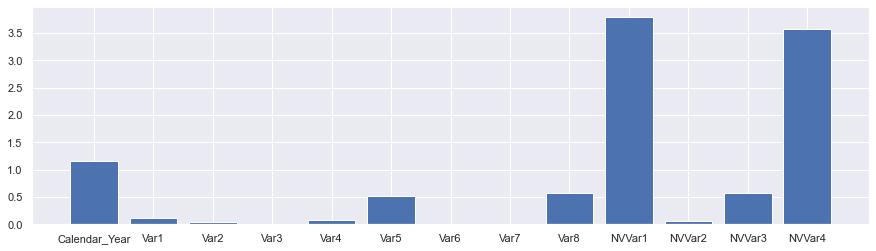

In [24]:
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (predictors[i], fs.scores_[i]))

# plot the scores
plt.figure(figsize=(15,4))
plt.bar(predictors, fs.scores_)
plt.show()

In [25]:
#predictors = ['Calendar_Year', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
predict = ['Calendar_Year', 'Var5', 'Var8', 'NVVar1', 'NVVar3', 'NVVar4']#, 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
#predict = ['NVVar1', 'NVVar4']
RMSEs, R2s, MAEs, lrm = MultiLinear(dfc, predictors=predict)

print(f'The value of root mean squared error is: {RMSEs[0]:.4f} (training)')
print(f'The value of root mean squared error is: {RMSEs[1]:.4f} (testing)')

print(f'The value of R2 is: {R2s[0]:.4f} (training)')
print(f'The value of R2 is: {R2s[1]:.4f} (testing)')

print(f'The value of mean absolute error is: {MAEs[0]:.4f} (training)')
print(f'The value of mean absolute error is: {MAEs[1]:.4f} (testing)')


The value of root mean squared error is: 32.7906 (training)
The value of root mean squared error is: 60.5463 (testing)
The value of R2 is: 0.0001 (training)
The value of R2 is: -0.0002 (testing)
The value of mean absolute error is: 3.2899 (training)
The value of mean absolute error is: 4.0018 (testing)


In [26]:
# coefficients
print(f"Bias term is {lrm.intercept_:0.3f}")
for count, coef in enumerate(lrm.coef_):
    print(f"{predict[count]} - w_{count+1}={coef:0.3f}")

Bias term is 296.632
Calendar_Year - w_1=-0.147
Var5 - w_2=0.137
Var8 - w_3=-0.100
NVVar1 - w_4=0.204
NVVar3 - w_5=0.101
NVVar4 - w_6=0.203


That did not improve the results that much either. Maybe we can try __regularization__ approaches. I am going to try `Ridge` and `LASSO` regressions. And I will include all the numerical features. Let's start with __Ridge regression__.

In [27]:
# including all the numerical features
predict = ['Calendar_Year', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
# training the model and getting the results
RMSEs_rg, R2s_rg, MAEs_rg, lrg = MultiLinear(dfc, predictors=predict, algorithm='RG')

print(f'The value of root mean squared error is: {RMSEs_rg[0]:.4f} (training)')
print(f'The value of root mean squared error is: {RMSEs_rg[1]:.4f} (testing)')

print(f'The value of R2 is: {R2s_rg[0]:.4f} (training)')
print(f'The value of R2 is: {R2s_rg[1]:.4f} (testing)')

print(f'The value of mean absolute error is: {MAEs_rg[0]:.4f} (training)')
print(f'The value of mean absolute error is: {MAEs_rg[1]:.4f} (testing)')

weights_rg = np.insert(lrg.coef_, 0, lrg.intercept_)
print(f"The weights using Ridge regression are:\n {weights_rg}")

The value of root mean squared error is: 32.7902 (training)
The value of root mean squared error is: 60.5459 (testing)
The value of R2 is: 0.0002 (training)
The value of R2 is: -0.0002 (testing)
The value of mean absolute error is: 3.2901 (training)
The value of mean absolute error is: 4.0019 (testing)
The weights using Ridge regression are:
 [ 2.88194145e+02 -1.42841564e-01 -2.66534505e-01  2.80707221e-01
 -1.84435343e-01 -2.99230982e-01  4.04949152e-01  1.51436336e-01
  5.41602441e-02 -1.31473044e-01  2.01724449e-01 -1.76355434e-02
  1.00210505e-01  1.98965144e-01]


And then using Lasso

In [28]:
# training the model and getting the results
RMSEs_ls, R2s_ls, MAEs_ls, lso = MultiLinear(dfc, predictors=predict, algorithm='LSO')

print(f'The value of root mean squared error is: {RMSEs_ls[0]:.4f} (training)')
print(f'The value of root mean squared error is: {RMSEs_ls[1]:.4f} (testing)')

print(f'The value of R2 is: {R2s_ls[0]:.4f} (training)')
print(f'The value of R2 is: {R2s_ls[1]:.4f} (testing)')

print(f'The value of mean absolute error is: {MAEs_ls[0]:.4f} (training)')
print(f'The value of mean absolute error is: {MAEs_ls[1]:.4f} (testing)')

weights_ls = np.insert(lso.coef_, 0, lso.intercept_)
print(f"The weights using LASSO regression are:\n {weights_ls}")

The value of root mean squared error is: 32.7927 (training)
The value of root mean squared error is: 60.5430 (testing)
The value of R2 is: 0.0000 (training)
The value of R2 is: -0.0001 (testing)
The value of mean absolute error is: 3.2909 (training)
The value of mean absolute error is: 4.0058 (testing)
The weights using LASSO regression are:
 [ 1.66159824 -0.          0.         -0.         -0.         -0.
  0.          0.         -0.         -0.          0.         -0.
  0.          0.        ]


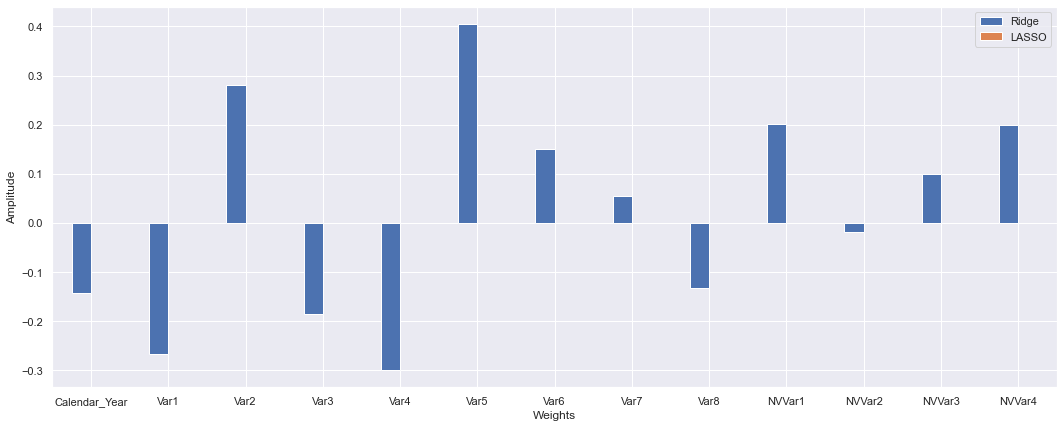

In [29]:
# generating the labels
xlabel =[]
for v in range(len(weights_rg[1:])):
    xlabel.append(predict[v])

# --------- plotting the weights
# Setting the font size
plt.rcParams.update({'font.size': 20})
# Putting the weights into a dataframe
df_wt = pd.DataFrame({'Ridge':weights_rg[1:], 'LASSO':weights_ls[1:]})
# Plotting the weights
fig=df_wt.plot.bar( figsize=(18,7) )
plt.xlabel("Weights")
plt.ylabel("Amplitude")
plt.xticks(rotation = 0)
plt.xticks(np.arange(len(weights_rg[1:])), xlabel)
plt.grid(b=True) 

Finally, let's compare the performance of the models using the three performance evaluation metrics.

[Text(0, 0, 'Training'), Text(1, 0, 'Testing')]

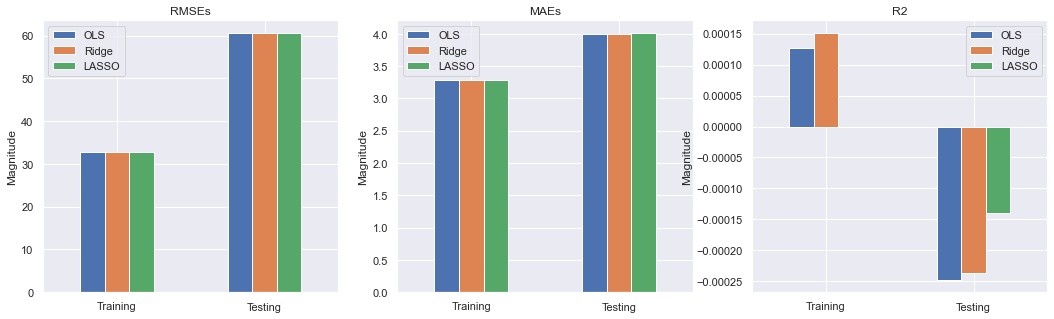

In [30]:
# --------- plotting the performance evaluation metrics
# Setting the font size
plt.rcParams.update({'font.size': 20})
xlabel = ['Training', 'Testing']
# Putting the weights into a dataframe
df_perf_rmse = pd.DataFrame({'OLS':RMSEs, 'Ridge':RMSEs_rg, 'LASSO':RMSEs_ls})
df_perf_mae = pd.DataFrame({'OLS':MAEs, 'Ridge':MAEs_rg, 'LASSO':MAEs_ls})
df_perf_r2 = pd.DataFrame({'OLS':R2s, 'Ridge':R2s_rg, 'LASSO':R2s_ls})

# Plotting the performance eval metrics
fig, axes = plt.subplots(nrows=1, ncols=3 ,figsize=(18,5))

df_perf_rmse.plot( ax=axes[0], kind='bar', grid=True )
axes[0].set_title("RMSEs")
axes[0].set_ylabel("Magnitude")
axes[0].set_xticks([0,1]) 
axes[0].set_xticklabels(xlabel, rotation=0)

df_perf_mae.plot( ax=axes[1], kind='bar', grid=True )
axes[1].set_title("MAEs")
axes[1].set_ylabel("Magnitude")
axes[1].set_xticklabels(xlabel, rotation=0)

df_perf_r2.plot( ax=axes[2], kind='bar', grid=True )
axes[2].set_title("R2")
axes[2].set_ylabel("Magnitude")
axes[2].set_xticklabels(xlabel, rotation=0)

Looking at the performance evaluation metrics for testing data, it seems like the best model could be Ridge or LASSO (based on its performance on testing data). It is interesting to see that LASSO ended up eliminating all the features (zeroing the weights for all the features) and basically keeping only the bias term.

In [33]:
df_lg = df.copy() # making a copy
df_lg.drop(columns='Claim_Cat', inplace=True)
df_lg['Claim_Amount'] = df_lg['Claim_Amount'].apply(lambda x : 1 if x > 0 else 0)
df_lg['Claim_Amount'].value_counts()

0    100000
1      1000
Name: Claim_Amount, dtype: int64

So we have unbalanced data. Here, the majority case is `0` (no claim) and the minority case is `1` (claim).

Let's first implement the logistic regression using the numerical values only and with no customization and see the performance.

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

y_data = np.array(df_lg['Claim_Amount'])

predictors_no_cat = ['Calendar_Year', 'Var3', 'Var4', 'Var5', 'Var6', 'Var7', 'Var8', 'NVVar1', 'NVVar2', 'NVVar3', 'NVVar4']
x_data_no_cat = np.array( df_lg[predictors_no_cat] )

x_train_no_cat,x_test_no_cat,y_train_no_cat,y_test_no_cat=train_test_split(x_data_no_cat, y_data,
stratify = y_data,test_size=0.2, random_state=20)

lgr_no_cat = LogisticRegression().fit(x_train_no_cat, y_train_no_cat)

# prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores_no_cat = cross_val_score(lgr_no_cat, x_train_no_cat, y_train_no_cat, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(scores_no_cat)}')

F1-Score: 0.49751243781094534


Let's now incorporate the categorical variables for prediction to see if it improves the results. To do so, we need to introduce dummy variables.

In [35]:
# categorical variables
Categories = ['Calendar_Year','Cat1', 'Cat2', 'Cat3', 'Cat4', 'Cat5', 'Cat6', 'Cat7', 
'Cat8', 'Cat9', 'Cat10', 'Cat11', 'Cat12', 'OrdCat', 'NVCat']
# creating dummy variables
df_lg_one_hot_coded = pd.get_dummies(df_lg, columns=Categories, drop_first=True)
# dropping the columns: 'Row_ID','Household_ID','Vehicle','Model_Year','Blind_Make', 'Blind_Model','Blind_Submodel' 
# sine we are not using them
df_lg_one_hot_coded.drop(columns=['Row_ID','Household_ID','Vehicle','Model_Year','Blind_Make',
'Blind_Model','Blind_Submodel'], inplace=True)
# final dataframe
df_lg_one_hot_coded.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,NVVar1,NVVar2,...,NVCat_F,NVCat_G,NVCat_H,NVCat_I,NVCat_J,NVCat_K,NVCat_L,NVCat_M,NVCat_N,NVCat_O
0,-0.047204,0.048405,-0.268039,-0.021902,-0.186464,-0.107419,-0.763322,1.951802,-0.23153,-0.266117,...,0,0,0,0,0,0,0,0,0,1
1,1.061623,-1.300304,-0.615144,-1.341171,0.610453,-0.405695,0.170537,-0.939473,-0.23153,4.308482,...,0,0,0,0,1,0,0,0,0,0
2,-0.770352,-1.248430,-1.077951,-0.021902,-0.537345,-0.569455,-1.058225,-0.524981,-0.23153,-0.266117,...,0,0,0,0,0,0,0,1,0,0
3,0.900924,2.036887,1.560048,1.923173,0.937546,1.849506,1.546749,1.265357,-0.23153,-0.266117,...,0,0,0,0,0,0,0,0,0,1
4,2.130275,0.065696,1.675749,0.181062,2.043715,0.745300,1.239559,0.032490,-0.23153,-0.266117,...,0,0,0,0,0,0,0,1,0,0


Let's train a model using all the features from before and the added dummy features.

In [36]:
x_data_with_cats = np.array( df_lg_one_hot_coded.drop(columns=['Claim_Amount']) )

x_train_with_cats, x_test_with_cats, y_train_with_cats, y_test_with_cats = train_test_split(x_data_with_cats, y_data, 
stratify = y_data, test_size=0.2, random_state=25)

lgr_with_cats = LogisticRegression(max_iter=1000).fit(x_train_with_cats, y_train_with_cats)

# prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores_with_cats = cross_val_score(lgr_with_cats, x_train_with_cats, y_train_with_cats, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(scores_with_cats)}')

F1-Score: 0.49751243781094534


Ok. That didn't really improve the performance. Let's see if we can do some feature selection and find the best features for model development. Let's use recursive feature elimination function to see if we can find the most important features. In total, we have 77 features in our data set.

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

# define the method - select best features and rank them with eliminating 1 feature at a time (step=1)
rfe = RFE(estimator=LogisticRegression(max_iter=1000), step=1)
# fit the model
rfe.fit(x_train_with_cats, y_train_with_cats)

# evaluate model
cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

n_scores_with_cats_rfe = cross_val_score(rfe, x_train_with_cats, y_train_with_cats, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(n_scores_with_cats_rfe)}')


F1-Score: 0.49751243781094534


So the selected features are as follows.

In [56]:
selected_features = df_lg_one_hot_coded.drop(columns=['Claim_Amount']).columns[rfe.support_]
selected_features

Index(['Var1', 'Var5', 'Cat1_D', 'Cat1_F', 'Cat1_J', 'Cat2_B', 'Cat3_C',
       'Cat3_D', 'Cat3_E', 'Cat3_F', 'Cat4_B', 'Cat4_C', 'Cat5_C', 'Cat6_C',
       'Cat6_D', 'Cat6_E', 'Cat6_F', 'Cat7_B', 'Cat7_D', 'Cat8_B', 'Cat9_B',
       'Cat10_C', 'Cat11_C', 'Cat11_D', 'Cat12_F', 'OrdCat_3', 'OrdCat_5',
       'OrdCat_6', 'NVCat_B', 'NVCat_C', 'NVCat_D', 'NVCat_E', 'NVCat_G',
       'NVCat_H', 'NVCat_I', 'NVCat_K', 'NVCat_M', 'NVCat_O'],
      dtype='object')

Let's check out the performance using these features.

In [39]:
x_data_with_selected_features = np.array( df_lg_one_hot_coded[selected_features] )

x_train_with_selected_features, x_test_with_selected_features, y_train_with_selected_features, y_test_with_selected_features = train_test_split(
    x_data_with_selected_features, y_data, stratify=y_data, test_size=0.2, random_state=50)

lgr_with_selected_features = LogisticRegression(max_iter=1000).fit(x_train_with_selected_features, y_train_with_selected_features)

# prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores_with_selected_features = cross_val_score(lgr_with_selected_features, x_train_with_selected_features, y_train_with_selected_features, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(scores_with_selected_features)}')

F1-Score: 0.49751243781094534


In [40]:
# coefficients
print(f"Bias term is {lgr_with_selected_features.intercept_[0]:0.5f}")
for count, coef in enumerate(lgr_with_selected_features.coef_[0]):
    print(f"{selected_features[count]} - weight_{count+1}={coef:0.5f}")

Bias term is -4.25301
Var1 - weight_1=-0.18233
Var5 - weight_2=0.38479
Cat1_D - weight_3=-0.37244
Cat1_F - weight_4=0.40943
Cat1_J - weight_5=0.14831
Cat2_B - weight_6=0.34461
Cat3_C - weight_7=-0.38769
Cat3_D - weight_8=-0.39588
Cat3_E - weight_9=-0.07050
Cat3_F - weight_10=0.13201
Cat4_B - weight_11=-0.30450
Cat4_C - weight_12=-0.22753
Cat5_C - weight_13=0.15575
Cat6_C - weight_14=0.05807
Cat6_D - weight_15=-0.29756
Cat6_E - weight_16=-0.32069
Cat6_F - weight_17=0.13148
Cat7_B - weight_18=-0.50943
Cat7_D - weight_19=0.35447
Cat8_B - weight_20=-0.25320
Cat9_B - weight_21=0.19749
Cat10_C - weight_22=-0.16470
Cat11_C - weight_23=-0.16495
Cat11_D - weight_24=0.10380
Cat12_F - weight_25=0.09289
OrdCat_3 - weight_26=0.69086
OrdCat_5 - weight_27=-0.05596
OrdCat_6 - weight_28=0.43837
NVCat_B - weight_29=0.31521
NVCat_C - weight_30=-0.07279
NVCat_D - weight_31=0.24924
NVCat_E - weight_32=-0.24209
NVCat_G - weight_33=-0.08791
NVCat_H - weight_34=-0.11010
NVCat_I - weight_35=-0.19048
NVCat_K - 

The bias term or the intercept is just the log odds of having a claim when all other variables are zero, in this case the intercept value is -4.25301. This translates into an odd using $e^{-4.25301}$, which is about 0.0142, meaning the a claim (class 1) is about 0.0412 times more likely than no-claim (class 0). Equivalently, we can say the probability is $\frac{0.0142}{1+0.0142}=0.0140$. This means that the probability of having a claim is 0.014, assuming all other variables are zero.

Generally in logistic regression, the coefficient of each feature represents the change in log odds of having the outcome due to unit change in that feature. In other words, increasing the feature by one unit changes the log odds by the weight of the feature. For instance, a difference of 1 in Var5 corresponds to a positive difference of 0.38479 in the logit probability of having a claim. Or as another example, a difference of 1 in Cat3_C corresponds to a negative difference of 0.38769 in the logit probability of having a claim.


Let's use the last model developed using the selected features for this part.

Results for training data: ------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     80000
           1       0.00      0.00      0.00       800

    accuracy                           0.99     80800
   macro avg       0.50      0.50      0.50     80800
weighted avg       0.98      0.99      0.99     80800

Results for testing data: ------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20000
           1       0.00      0.00      0.00       200

    accuracy                           0.99     20200
   macro avg       0.50      0.50      0.50     20200
weighted avg       0.98      0.99      0.99     20200



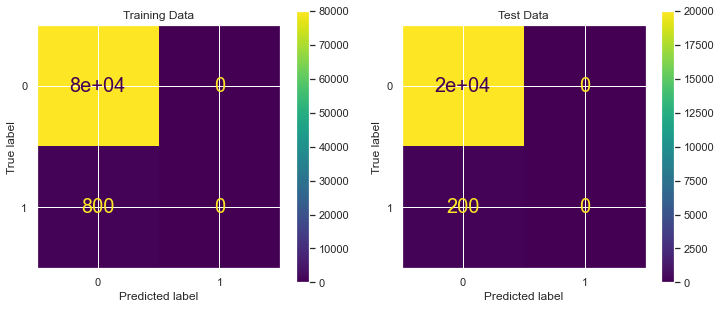

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

yhat_with_selected_features_train=lgr_with_selected_features.predict(x_train_with_selected_features)
yhat_with_selected_features_test=lgr_with_selected_features.predict(x_test_with_selected_features)

# getting a report on the performance for each class
print("Results for training data:",30*"-")
print( classification_report(y_train_with_selected_features, yhat_with_selected_features_train, zero_division=0) )
print("Results for testing data:", 30*"-")
print( classification_report(y_test_with_selected_features, yhat_with_selected_features_test, zero_division=0) )

# finding confusion matrix
cm_score_train = confusion_matrix(y_train_with_selected_features, yhat_with_selected_features_train)
cm_score_test = confusion_matrix(y_test_with_selected_features, yhat_with_selected_features_test)

# creating confusion matrix plots
conf_matrix_train = ConfusionMatrixDisplay(cm_score_train, display_labels=lgr_with_selected_features.classes_)
conf_matrix_test = ConfusionMatrixDisplay(cm_score_test, display_labels=lgr_with_selected_features.classes_)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12,5))
conf_matrix_train.plot(ax=axs[0])
axs[0].set_title(f"Training Data")
conf_matrix_test.plot(ax=axs[1])
axs[1].set_title("Test Data");


Here, precision, recall and F-1 are defined as

precision = $\frac{TP}{TP+FP}$

recall =$\frac{TP}{TP+FN}$

F-1 = $\frac{2}{\frac{1}{\text{recall}} \times \frac{1}{\text{precision}}}$ = $2\frac{\text{precision}\times\text{recall}}{ \text{precision}+\text{recall} }$

So these results basically tell me that the developed model is classifying every single entry as 0. Since 99% of the data is class 0, we end up getting a precision of 0.99 and recall of 1 for class 0, whereas thess two are zero for class 1. F-1 score values are reported as 0 if both recall and precision were zero or one of them were zero. 

So I need to find a better way of developing a classification model for this unbalanced data set.

I explore two options:
1. Undersampling
2. Oversampling

I start with __Undersamplig__

In [42]:
# dataframe with class 0
df_class_0 = df_lg_one_hot_coded[ df_lg_one_hot_coded['Claim_Amount']==0]
# dataframe with class 1
df_class_1 = df_lg_one_hot_coded[ df_lg_one_hot_coded['Claim_Amount']==1]
print(len(df_class_0), len(df_class_1))

100000 1000


In [43]:
index_class_0 = list( range(len( df_class_0 )) )
# split the part of dataframe with class majority into 100 equal-sized dataframes
index_random = np.array_split(index_class_0, 100)
np.random.shuffle(index_random)
df_class_0_tmp = df_lg_one_hot_coded.iloc[ index_random[0] ]
# creating a new dataframe with 1000 rows of 1's and 1000 randomly selected rows of 0's
df_sub = pd.concat([df_class_1, df_class_0_tmp], axis=0) 
print(df_sub.shape)

(2000, 77)


NPW, let's develop a model using this perfectly balanced data set.

In [44]:
# now use this data set to develop a model 
x_data_sub = np.array( df_sub.drop(columns=['Claim_Amount']) )
y_data_sub = np.array( df_sub['Claim_Amount'])

x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_data_sub, y_data_sub, stratify=y_data_sub, test_size=0.2, random_state=50)

lgr_sub = LogisticRegression(max_iter=1000).fit(x_train_sub, y_train_sub)

# prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores_sub = cross_val_score(lgr_sub, x_train_sub, y_train_sub, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(scores_sub)}')

F1-Score: 0.5540880941288322


It seems like model's F-1 score has improved for this perfectly balanced data set. Let's look at the full report with precision, recall, and F-1 score for each class.

Results for training data: ------------------------------
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       800
           1       0.61      0.61      0.61       800

    accuracy                           0.61      1600
   macro avg       0.61      0.61      0.61      1600
weighted avg       0.61      0.61      0.61      1600

Results for testing data: ------------------------------
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       200
           1       0.57      0.58      0.58       200

    accuracy                           0.57       400
   macro avg       0.58      0.57      0.57       400
weighted avg       0.58      0.57      0.57       400



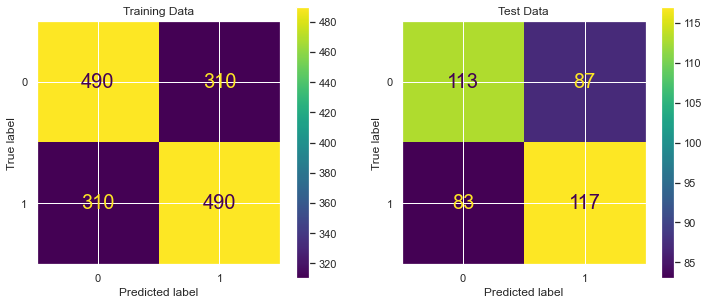

In [45]:
yhat_sub_train=lgr_sub.predict(x_train_sub)
yhat_sub_test=lgr_sub.predict(x_test_sub)

# getting a report on the performance for each class
print("Results for training data:",30*"-")
print( classification_report(y_train_sub, yhat_sub_train, zero_division=0) )
print("Results for testing data:",30*"-")
print( classification_report(y_test_sub, yhat_sub_test, zero_division=0) )

# finding confusion matrix
cm_score_sub_train = confusion_matrix(y_train_sub, yhat_sub_train)
cm_score_sub_test = confusion_matrix(y_test_sub, yhat_sub_test)

# creating confusion matrix plots
conf_matrix_sub_train = ConfusionMatrixDisplay(cm_score_sub_train, display_labels=lgr_sub.classes_)
conf_matrix_sub_test = ConfusionMatrixDisplay(cm_score_sub_test, display_labels=lgr_sub.classes_)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12,5))
conf_matrix_sub_train.plot(ax=axs[0])
axs[0].set_title(f"Training Data")
conf_matrix_sub_test.plot(ax=axs[1])
axs[1].set_title("Test Data");

Let's see if we can improve the model more by training the model on training data with the same data of class 1 and 100 sets of data of class 0. Here, I will do __oversampling__. To do that, I will repeat the class 1 part of the dataframe 100 times and create a new dataframe for model development.

In [46]:
df_synthetic = pd.concat([pd.concat([df_class_1]*100), df_class_0], axis=0) 
df_synthetic['Claim_Amount'].value_counts()

1    100000
0    100000
Name: Claim_Amount, dtype: int64

Now, let's develop a model using this perfectly balanced data set.

In [47]:
# now use this data set to develop a model 
x_data_synthetic = np.array( df_synthetic.drop(columns=['Claim_Amount']) )
y_data_synthetic = np.array( df_synthetic['Claim_Amount'])

x_train_synthetic, x_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(x_data_synthetic, y_data_synthetic, stratify=y_data_synthetic, test_size=0.2, random_state=50)

lgr_synthetic= LogisticRegression(max_iter=1000).fit(x_train_synthetic, y_train_synthetic)

# prepare the cross-validation procedure
cv = StratifiedKFold(n_splits=10, random_state=256, shuffle=True)
# evaluate model
scores_synthetic = cross_val_score(lgr_synthetic, x_train_synthetic, y_train_synthetic, scoring='f1_macro', cv=cv, n_jobs=-1)
# report performance
print(f'F1-Score: {np.mean(scores_synthetic)}')

F1-Score: 0.5964139024437709


Looking at the performance report

Results for training data: ------------------------------
              precision    recall  f1-score   support

           0       0.60      0.59      0.59     80000
           1       0.60      0.61      0.60     80000

    accuracy                           0.60    160000
   macro avg       0.60      0.60      0.60    160000
weighted avg       0.60      0.60      0.60    160000

Results for testing data: ------------------------------
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     20000
           1       0.59      0.60      0.60     20000

    accuracy                           0.59     40000
   macro avg       0.59      0.59      0.59     40000
weighted avg       0.59      0.59      0.59     40000



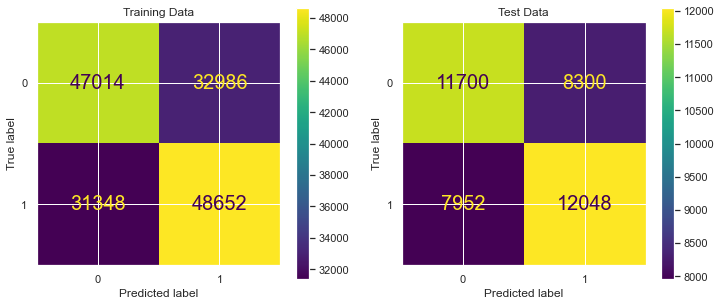

In [48]:
yhat_syn_train=lgr_synthetic.predict(x_train_synthetic)
yhat_syn_test=lgr_synthetic.predict(x_test_synthetic)

# getting a report on the performance for each class
print("Results for training data:",30*"-")
print( classification_report(y_train_synthetic, yhat_syn_train, zero_division=0) )
print("Results for testing data:",30*"-")
print( classification_report(y_test_synthetic, yhat_syn_test, zero_division=0) )

# finding confusion matrix
cm_score_syn_train = confusion_matrix(y_train_synthetic, yhat_syn_train)
cm_score_syn_test = confusion_matrix(y_test_synthetic, yhat_syn_test)

# creating confusion matrix plots
conf_matrix_syn_train = ConfusionMatrixDisplay(cm_score_syn_train, display_labels=lgr_synthetic.classes_)
conf_matrix_syn_test = ConfusionMatrixDisplay(cm_score_syn_test, display_labels=lgr_synthetic.classes_)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(12,5))
conf_matrix_syn_train.plot(ax=axs[0])
axs[0].set_title(f"Training Data")
conf_matrix_syn_test.plot(ax=axs[1])
axs[1].set_title("Test Data");


This could improve the performance of the model for the testing data.